In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


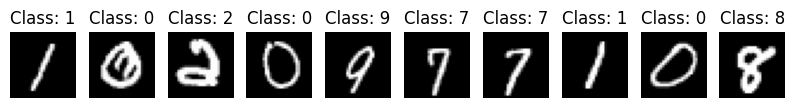

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        # First, we need to convert the input image to a vector by using 
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()
        
        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes 
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)
        
    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [7]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


In [8]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [11]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5033537995020548, accuracy: 87.57916666666667
Epoch 0: val. loss: 0.4964195895702281, val. accuracy: 87.6
Epoch 1: training loss: 0.42253071077664694, accuracy: 88.94166666666666
Epoch 1: val. loss: 0.41379196815034175, val. accuracy: 88.85833333333333
Epoch 2: training loss: 0.38834520983695986, accuracy: 89.64166666666667
Epoch 2: val. loss: 0.3789412074900688, val. accuracy: 89.44166666666666
Epoch 3: training loss: 0.368252578496933, accuracy: 90.07083333333334
Epoch 3: val. loss: 0.3586125836727467, val. accuracy: 89.91666666666667
Epoch 4: training loss: 0.35459072089195254, accuracy: 90.38958333333333
Epoch 4: val. loss: 0.3449194390088954, val. accuracy: 90.24166666666666
CPU times: user 44.6 s, sys: 10.1 s, total: 54.7 s
Wall time: 39.7 s


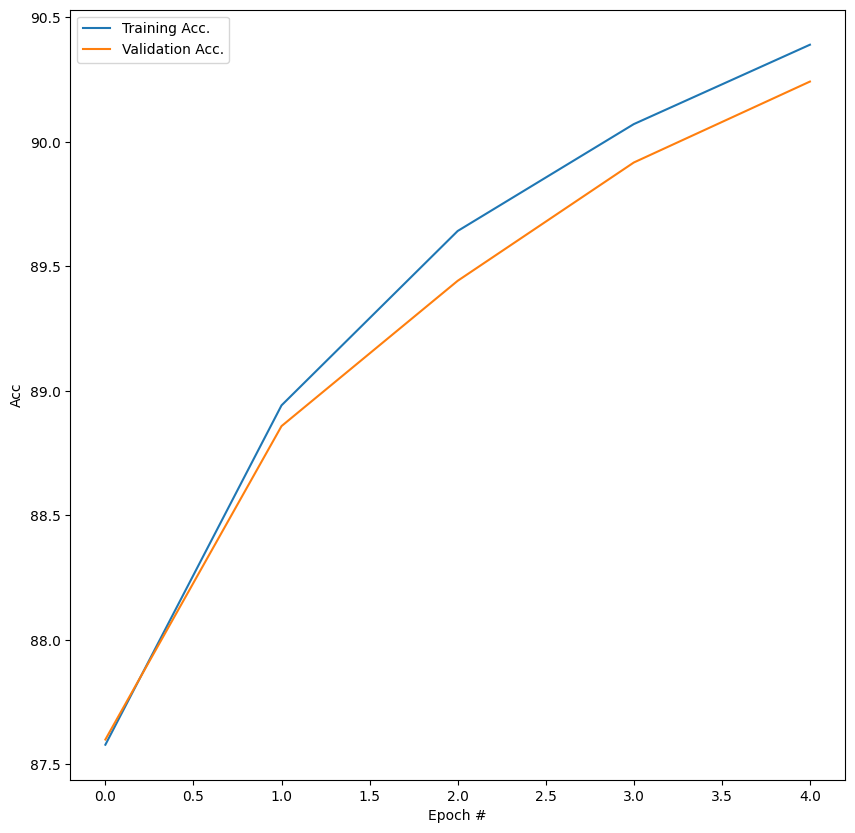

In [12]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Acc')
plt.legend()

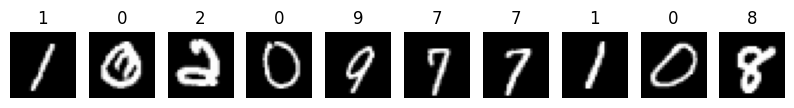

In [13]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

In [16]:
predictions[i,:]

tensor([-2.2942, -3.4898, -1.0467, -0.0506, -0.8220,  2.9399, -4.1829,  0.3990,
         6.0160,  2.0197], grad_fn=<SliceBackward0>)

In [18]:
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 256 
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [19]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3328, test accuracy: 90.77%


In [20]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


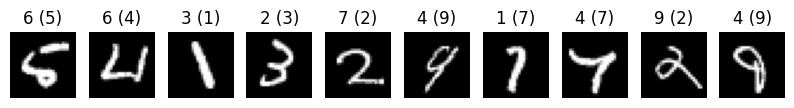

In [21]:
show_failures(linear_model, test_dataloader)

In [22]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [23]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [24]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7645283946990967, accuracy: 77.71041666666667
Epoch 0: val. loss: 0.7568640873787251, val. accuracy: 77.75833333333333
Epoch 1: training loss: 0.3957822641134262, accuracy: 88.67083333333333
Epoch 1: val. loss: 0.3901465291038473, val. accuracy: 88.56666666666668
Epoch 2: training loss: 0.30161078095436095, accuracy: 91.2875
Epoch 2: val. loss: 0.29656851513588683, val. accuracy: 91.09166666666667
Epoch 3: training loss: 0.24992253653208416, accuracy: 92.71249999999999
Epoch 3: val. loss: 0.24815062338367422, val. accuracy: 92.4
Epoch 4: training loss: 0.21211313726504644, accuracy: 93.74583333333332
Epoch 4: val. loss: 0.21092211827635765, val. accuracy: 93.46666666666667
CPU times: user 1min 7s, sys: 32.1 s, total: 1min 39s
Wall time: 45.3 s


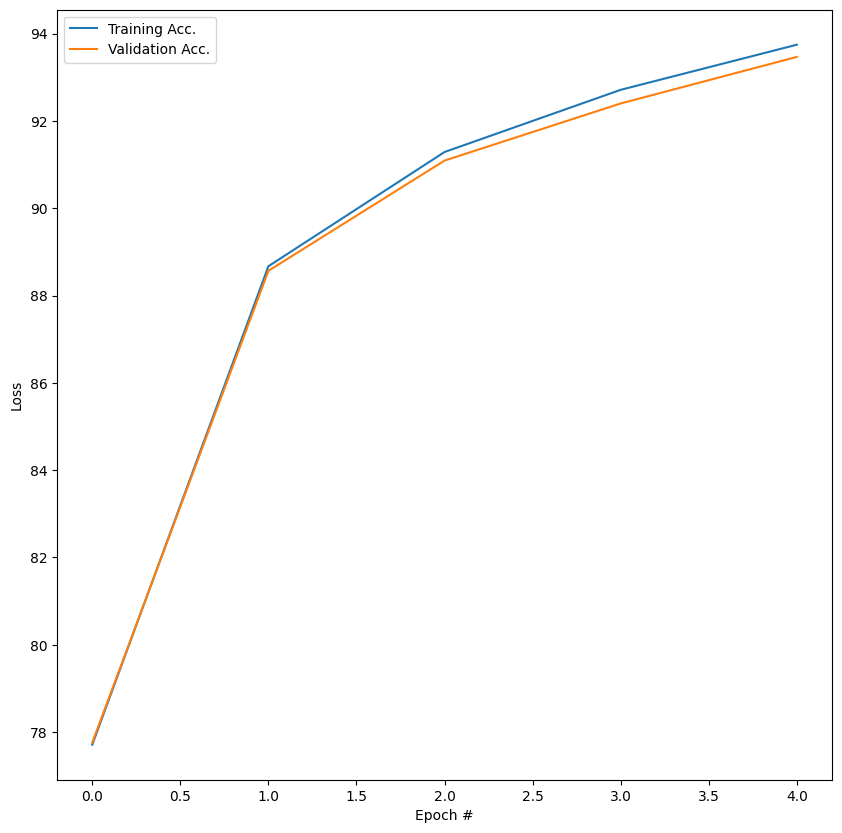

In [25]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


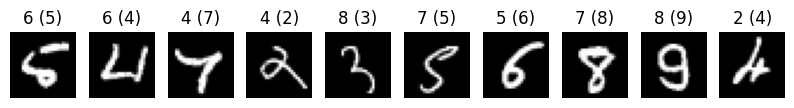

In [26]:
show_failures(nonlinear_model, test_dataloader)

# Homework

1. Compare the quality of your model when using different:
 - batch sizes, 
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization. 

# HW Solution

In [27]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [34]:
def train(model, batchsize=128, lr=0.05, epochs=5):
    batch_size = batchsize
    lr = lr
    model = model

    loss_fn = nn.CrossEntropyLoss()
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Step learning rate scheduler: reduce by a factor of 0.1 every 2 epochs (only for illustrative purposes)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


    epochs = epochs
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
        
        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
        
        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")
    
    pltsize=1
    plt.figure(figsize=(10*pltsize, 10 * pltsize))
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()

Epoch 0: training loss: 0.66568364828825, accuracy: 80.25208333333333
Epoch 0: val. loss: 0.6587483529249827, val. accuracy: 80.35
Epoch 1: training loss: 0.3723737770318985, accuracy: 89.31458333333333
Epoch 1: val. loss: 0.3641777195930481, val. accuracy: 89.54166666666666
Epoch 2: training loss: 0.28764559496566655, accuracy: 91.625
Epoch 2: val. loss: 0.2777331822713216, val. accuracy: 91.83333333333333
Epoch 3: training loss: 0.2446718137897551, accuracy: 92.74166666666666
Epoch 3: val. loss: 0.2368003580123186, val. accuracy: 92.91666666666667
Epoch 4: training loss: 0.2184873276768873, accuracy: 93.37083333333334
Epoch 4: val. loss: 0.21228600510954856, val. accuracy: 93.54166666666667
Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.
Epoch 0: training loss: 0.19868884236117204, accuracy: 94.05833333333334
Epoch 0: val. loss: 0.19433791938416184, val. accuracy: 94.13333333333334
Epoch 1: training loss: 0.19031606773535412, ac

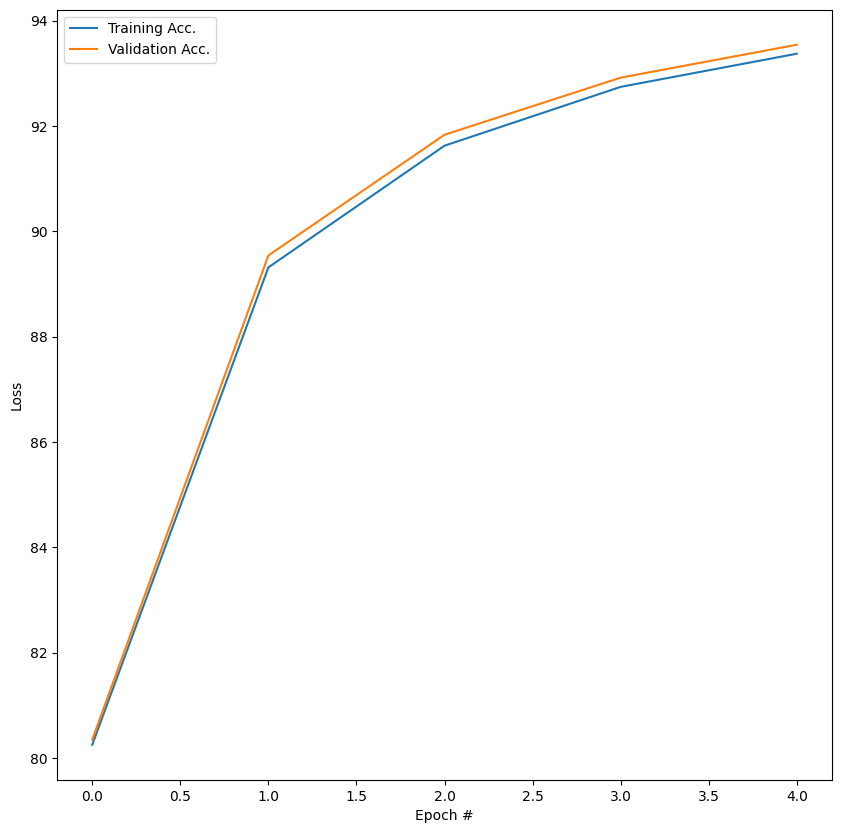

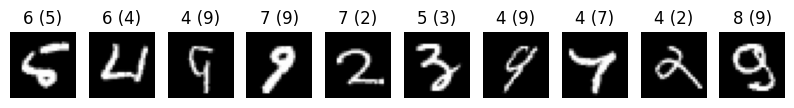

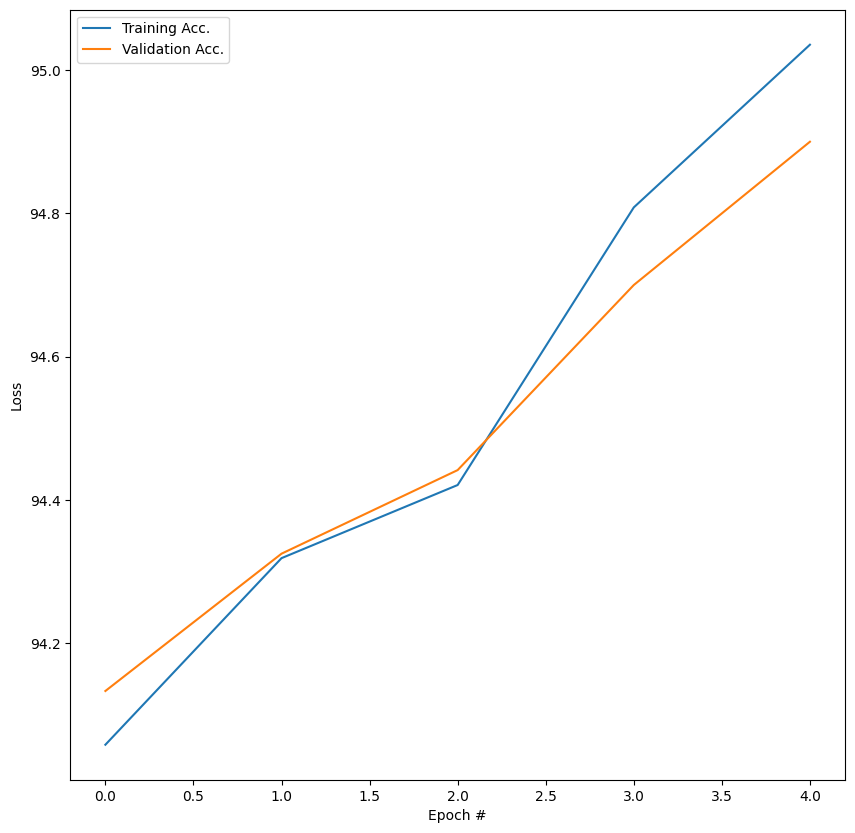

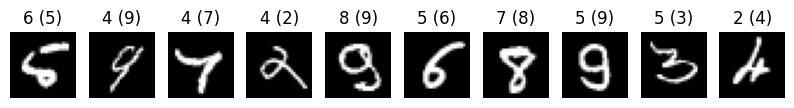

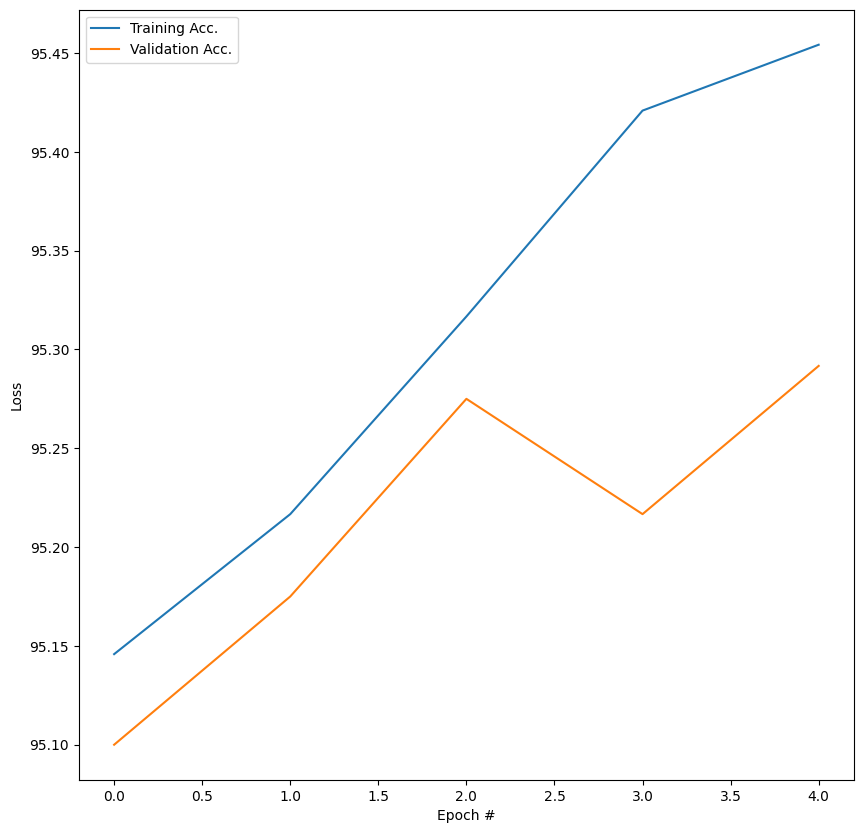

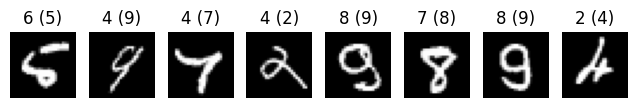

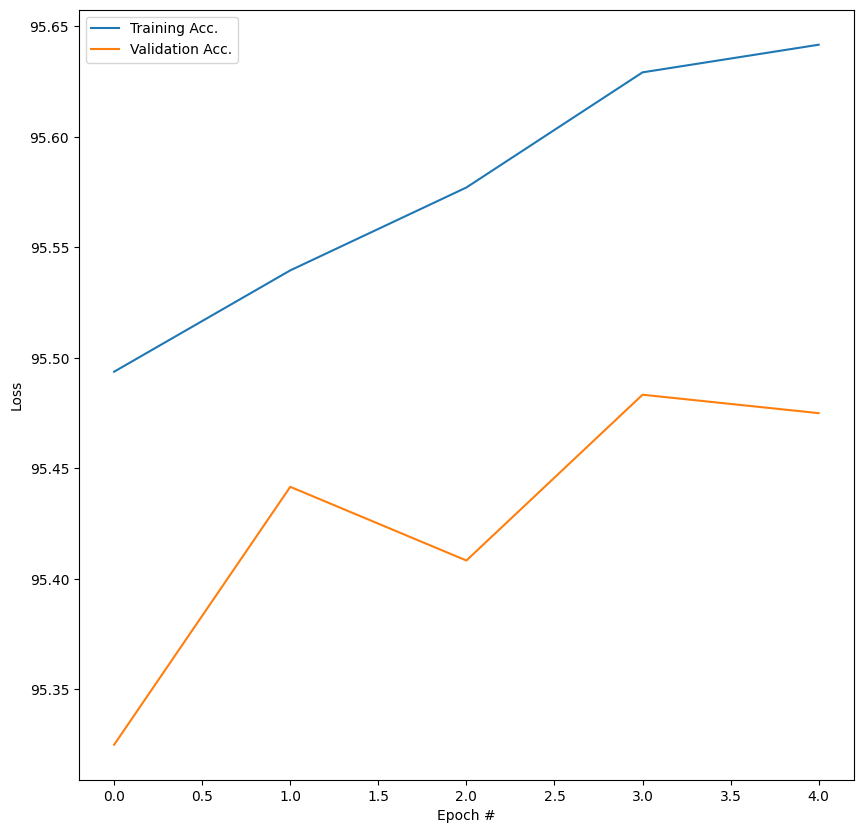

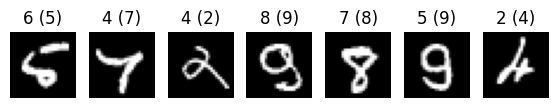

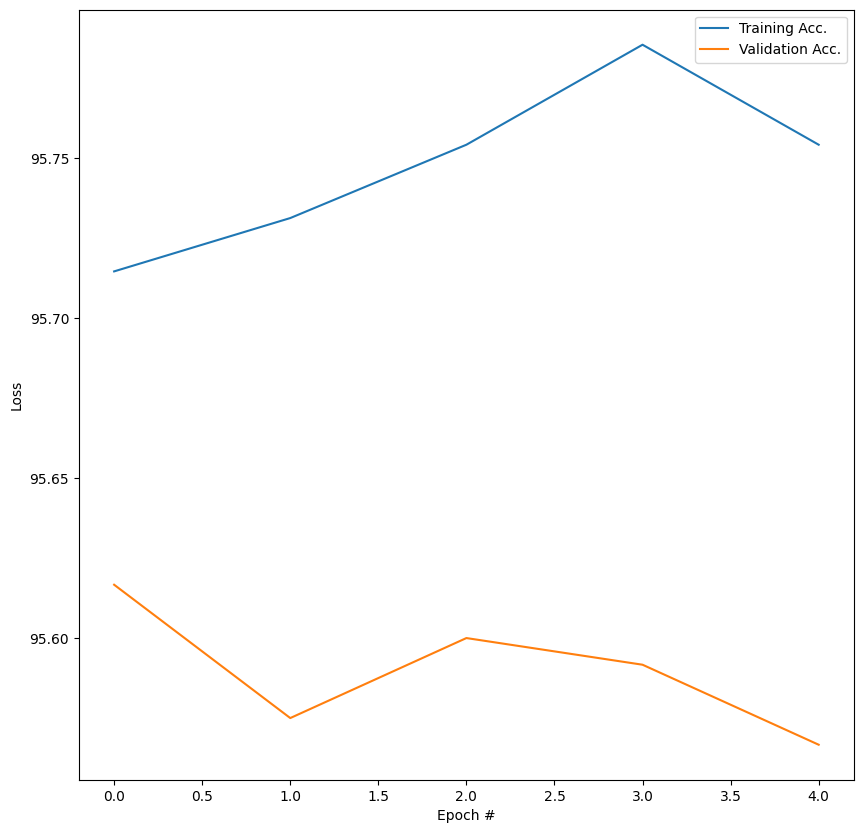

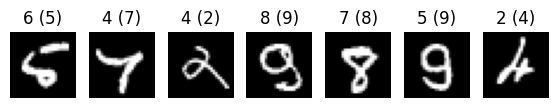

In [35]:
%%time
# Varying batchsize
nonlinear_model = NonlinearClassifier()

for batch_size in [32,64,128,256,512]:
    train(nonlinear_model, batchsize = batch_size)
    show_failures(nonlinear_model, test_dataloader)

### What is a learning rate scheduler?Bonus: What is a learning rate scheduler?

A learning rate scheduler is a mechanism within a machine learning model that dynamically adjusts the learning rate during the training process, typically by decreasing it over time, allowing for larger updates at the beginning of training and smaller, more fine-tuned updates as the model converges towards an optimal solution; this helps to improve training stability and prevent overfitting.